In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

print(tf.__version__)

2.8.0


In [10]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(f"train: {train.shape}, test: {test.shape}")

train: (42000, 785), test: (28000, 784)


In [12]:
y_train_full = train['label']
X_train_full = train.drop('label', axis=1)
X_train_full = X_train_full.values.reshape(-1, 28, 28, 1)
X_test = test.values.reshape(-1, 28, 28, 1)
X_test = X_test / 255.

print(f"train: {X_train_full.shape}, test: {X_test.shape}")

train: (42000, 28, 28, 1), test: (28000, 28, 28, 1)


Index: 34688
Image shape: (28, 28, 1)


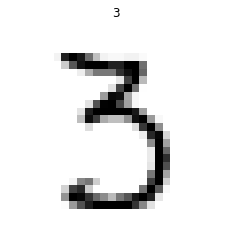

In [ ]:
def display_image(index):
  print(f"Index: {index}")
  img = X_train_full[index] / 255.
  target_class = y_train_full[index]

  plt.imshow(img.squeeze(axis=-1), cmap='binary')
  plt.axis("off")
  plt.title(target_class)
  print(f"Image shape: {img.shape}")

display_image(random.randint(0, X_train_full.shape[0]))

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1)
print(f"train: {X_train.shape}, vaildation: {X_valid.shape}")

X_train_lr = X_train / 255. # for finding the best initial learning rate for each model configuration

datagen_train = ImageDataGenerator(rescale=1/255.,
                             rotation_range=15,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             zoom_range=0.15)
datagen_valid = ImageDataGenerator(rescale=1/255.)
datagen_train.fit(X_train)
datagen_valid.fit(X_valid)

train: (37800, 28, 28, 1), vaildation: (4200, 28, 28, 1)


In [15]:
results_cols = ['Model', 'loss', 'accuracy']
results = pd.DataFrame(columns=results_cols)

## Base model

In [16]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal',
                               padding='same', input_shape=[28, 28, 1]),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2),
                               activation='elu', kernel_initializer='he_normal',
                               padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(50, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 global_average_pooling2d_1   (None, 128)              0         
 (GlobalAveragePooling2D)                             

#### Finding the best initial learning rate for the optimizer

In [45]:
import math


K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)


def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [46]:
def calc_lr(model, opt, batch_size=128):
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  rates, losses = find_learning_rate(model, X_train_lr, y_train, epochs=1, batch_size=batch_size)
  plot_lr_vs_loss(rates, losses)
  plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

296/296 [==============================] - 15s 14ms/step - loss: 166.4016 - accuracy: 0.3524


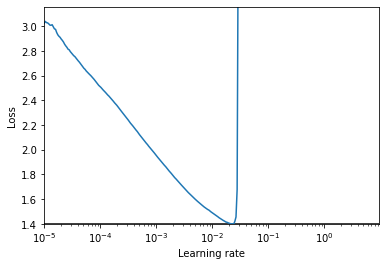

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
calc_lr(model, optimizer)

1e-3 is a good choice for initial learning rate for the adam optimizer.

In [100]:
def custom_fit(model, opt, batch_size=32, name=""):
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model" + name + ".h5", save_best_only=True)

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(datagen_train.flow(X_train, y_train, batch_size=batch_size), epochs=100,
            validation_data=datagen_valid.flow(X_valid, y_valid, batch_size=8),
            steps_per_epoch=len(X_train) / batch_size,
            callbacks=[early_stopping_cb, checkpoint_cb])
  return history

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-3 / 200)
history = custom_fit(model, opt)

Epoch 1/100
1181/1181 [==============================] - 36s 21ms/step - loss: 0.5784 - accuracy: 0.8176 - val_loss: 0.0992 - val_accuracy: 0.9698
Epoch 2/100
1181/1181 [==============================] - 26s 22ms/step - loss: 0.1942 - accuracy: 0.9450 - val_loss: 0.0898 - val_accuracy: 0.9719
Epoch 3/100
1181/1181 [==============================] - 21s 18ms/step - loss: 0.1548 - accuracy: 0.9570 - val_loss: 0.0627 - val_accuracy: 0.9798
Epoch 4/100
1181/1181 [==============================] - 25s 21ms/step - loss: 0.1310 - accuracy: 0.9637 - val_loss: 0.0742 - val_accuracy: 0.9769
Epoch 5/100
1181/1181 [==============================] - 17s 15ms/step - loss: 0.1173 - accuracy: 0.9683 - val_loss: 0.0560 - val_accuracy: 0.9826
Epoch 6/100
1181/1181 [==============================] - 28s 24ms/step - loss: 0.1072 - accuracy: 0.9706 - val_loss: 0.0574 - val_accuracy: 0.9819
Epoch 7/100
1181/1181 [==============================] - 21s 18ms/step - loss: 0.0965 - accuracy: 0.9743 - val_loss: 0

In [20]:
loss, accuracy = model.evaluate(datagen_valid.flow(X_valid, y_valid, batch_size=32))
results.loc[0, 'Model'] = 'Base line model'
results.loc[0, 'loss'] = loss
results.loc[0, 'accuracy'] = accuracy

132/132 [==============================] - 1s 4ms/step - loss: 0.0281 - accuracy: 0.9926


## Base model + Normalization

In [77]:
model_normal = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal',
                               padding='same', input_shape=[28, 28, 1]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2),
                               activation='elu', kernel_initializer='he_normal',
                               padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(50, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
])

296/296 [==============================] - 6s 16ms/step - loss: 22.7864 - accuracy: 0.5256


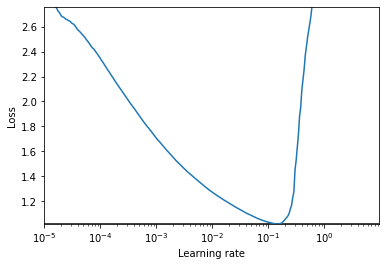

In [76]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
calc_lr(model_normal, optimizer)

In [78]:
opt_normal = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-4 / 200)
history_normal = custom_fit(model_normal, opt_normal, name="normal")

Epoch 1/100
1181/1181 [==============================] - 19s 15ms/step - loss: 1.0203 - accuracy: 0.6660 - val_loss: 0.2190 - val_accuracy: 0.9460
Epoch 2/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.4170 - accuracy: 0.8766 - val_loss: 0.1586 - val_accuracy: 0.9529
Epoch 3/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.2873 - accuracy: 0.9148 - val_loss: 0.0872 - val_accuracy: 0.9760
Epoch 4/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.2219 - accuracy: 0.9360 - val_loss: 0.0834 - val_accuracy: 0.9748
Epoch 5/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.1876 - accuracy: 0.9461 - val_loss: 0.0659 - val_accuracy: 0.9795
Epoch 6/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.1618 - accuracy: 0.9535 - val_loss: 0.0795 - val_accuracy: 0.9764
Epoch 7/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.1441 - accuracy: 0.9587 - val_loss: 0

In [79]:
loss, accuracy = model_normal.evaluate(datagen_valid.flow(X_valid, y_valid, batch_size=32))
results.loc[1, 'Model'] = 'Base line model with normalization'
results.loc[1, 'loss'] = loss
results.loc[1, 'accuracy'] = accuracy

132/132 [==============================] - 1s 4ms/step - loss: 0.0272 - accuracy: 0.9917


## Deeper model

In [26]:
model_deep = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal',
                               padding='same', input_shape=[28, 28, 1]),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal',
                               padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(50, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
])

296/296 [==============================] - 4s 11ms/step - loss: 7498480222208.0000 - accuracy: 0.3321


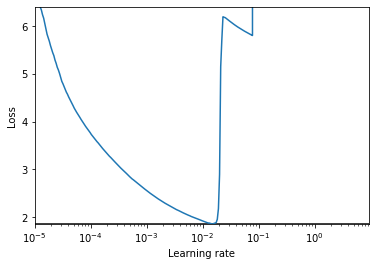

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
calc_lr(model_deep, optimizer)

In [27]:
opt_deep = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-4 / 200)
history_deep = custom_fit(model_deep, opt_deep, name="deep")

Epoch 1/100
1181/1181 [==============================] - 19s 15ms/step - loss: 1.2827 - accuracy: 0.5804 - val_loss: 0.2476 - val_accuracy: 0.9252
Epoch 2/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.4749 - accuracy: 0.8550 - val_loss: 0.1251 - val_accuracy: 0.9571
Epoch 3/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.3140 - accuracy: 0.9068 - val_loss: 0.0926 - val_accuracy: 0.9693
Epoch 4/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.2408 - accuracy: 0.9316 - val_loss: 0.0808 - val_accuracy: 0.9767
Epoch 5/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.2064 - accuracy: 0.9433 - val_loss: 0.0547 - val_accuracy: 0.9831
Epoch 6/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.1736 - accuracy: 0.9510 - val_loss: 0.0635 - val_accuracy: 0.9836
Epoch 7/100
1181/1181 [==============================] - 18s 15ms/step - loss: 0.1549 - accuracy: 0.9576 - val_loss: 0

In [56]:
loss, accuracy = model_deep.evaluate(datagen_valid.flow(X_valid, y_valid, batch_size=32))
results.loc[2, 'Model'] = 'Deeper model'
results.loc[2, 'loss'] = loss
results.loc[2, 'accuracy'] = accuracy

132/132 [==============================] - 1s 4ms/step - loss: 0.0215 - accuracy: 0.9943


## Deeper model with normalization

In [101]:
model_deep_normal = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal',
                               padding='same', input_shape=[28, 28, 1]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal',
                               padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(50, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
])

296/296 [==============================] - 5s 13ms/step - loss: 1263886.3750 - accuracy: 0.4949


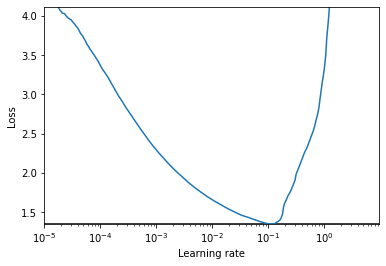

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
calc_lr(model_deep_normal, optimizer)

In [102]:
opt_deep_normal = tf.keras.optimizers.Adam(learning_rate=5e-4, decay=5e-4 / 200)
history_deep_normal = custom_fit(model_deep_normal, opt_deep_normal, name="deep_normal")

Epoch 1/100
1181/1181 [==============================] - 20s 16ms/step - loss: 0.7244 - accuracy: 0.7809 - val_loss: 0.0945 - val_accuracy: 0.9710
Epoch 2/100
1181/1181 [==============================] - 19s 16ms/step - loss: 0.2424 - accuracy: 0.9302 - val_loss: 0.0695 - val_accuracy: 0.9802
Epoch 3/100
1181/1181 [==============================] - 19s 16ms/step - loss: 0.1674 - accuracy: 0.9537 - val_loss: 0.0979 - val_accuracy: 0.9686
Epoch 4/100
1181/1181 [==============================] - 19s 16ms/step - loss: 0.1426 - accuracy: 0.9620 - val_loss: 0.0676 - val_accuracy: 0.9795
Epoch 5/100
1181/1181 [==============================] - 19s 16ms/step - loss: 0.1140 - accuracy: 0.9691 - val_loss: 0.0448 - val_accuracy: 0.9871
Epoch 6/100
1181/1181 [==============================] - 19s 16ms/step - loss: 0.1028 - accuracy: 0.9729 - val_loss: 0.0640 - val_accuracy: 0.9805
Epoch 7/100
1181/1181 [==============================] - 19s 16ms/step - loss: 0.0967 - accuracy: 0.9738 - val_loss: 0

In [83]:
loss, accuracy = model_deep_normal.evaluate(datagen_valid.flow(X_valid, y_valid, batch_size=32))
results.loc[3, 'Model'] = 'Deeper model with normalization'
results.loc[3, 'loss'] = loss
results.loc[3, 'accuracy'] = accuracy

132/132 [==============================] - 1s 4ms/step - loss: 0.0178 - accuracy: 0.9952


## Model selection and evaluation

In [85]:
results

,Model,loss,accuracy
0,Base line model,0.028103,0.992619
1,Base line model with normalization,0.027208,0.991667
2,Deeper model,0.021549,0.994286
3,Deeper model with normalization,0.017847,0.995238


The deeper model with batch normalization has the best results among the other therefore, we will use this model for the final prediction.

In [86]:
model_deep_normal.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 batch_normalization_22 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 batch_normalization_23 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

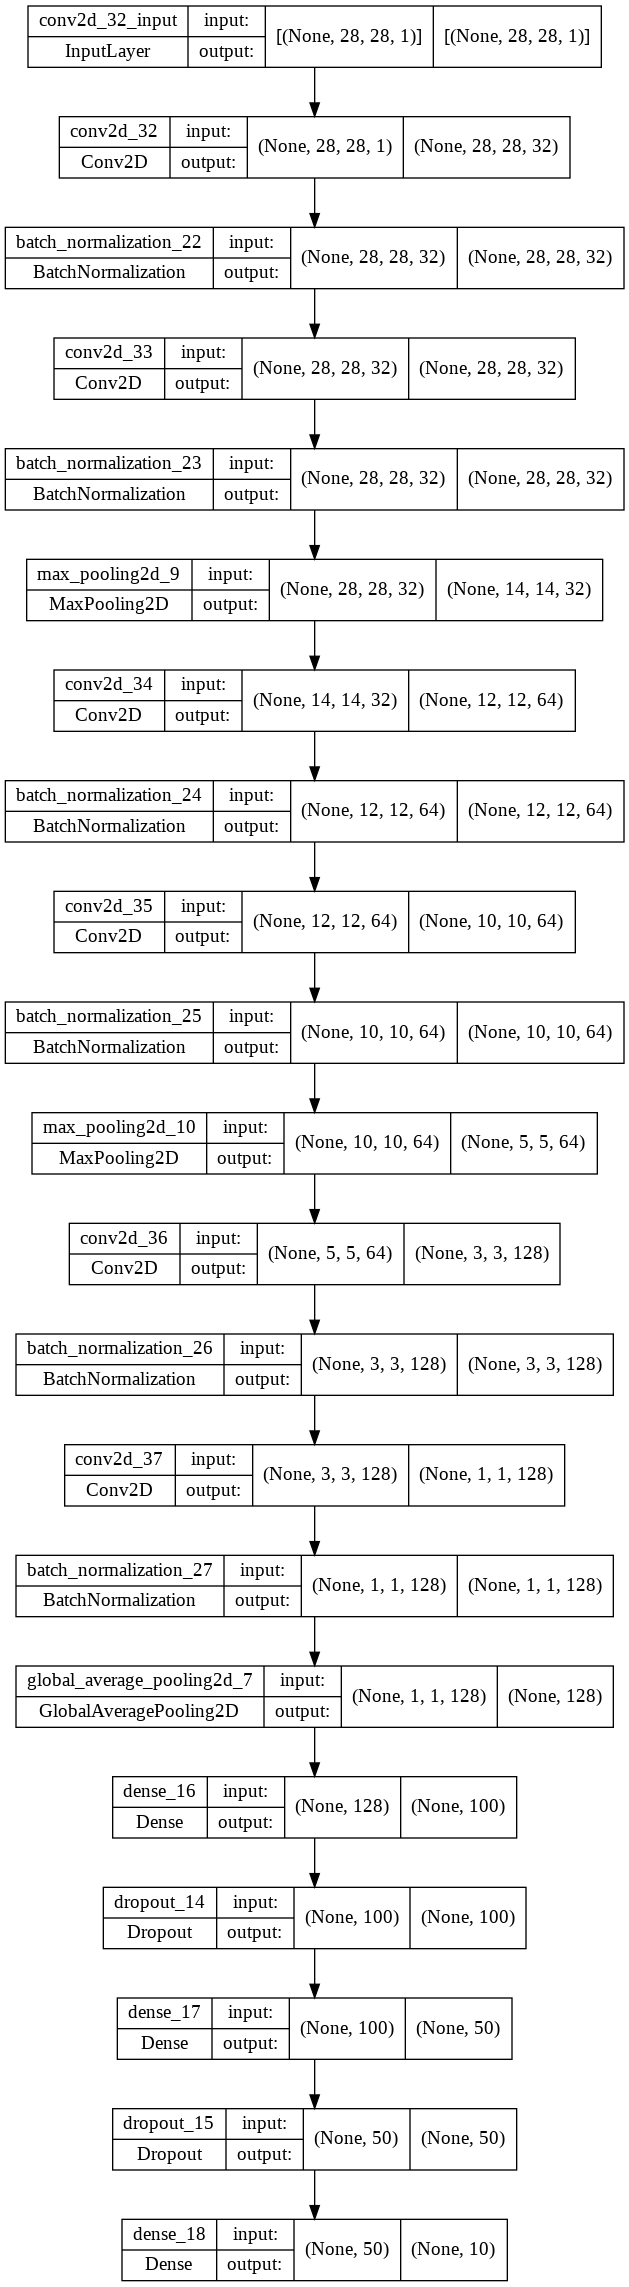

In [87]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(model_deep_normal, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png')

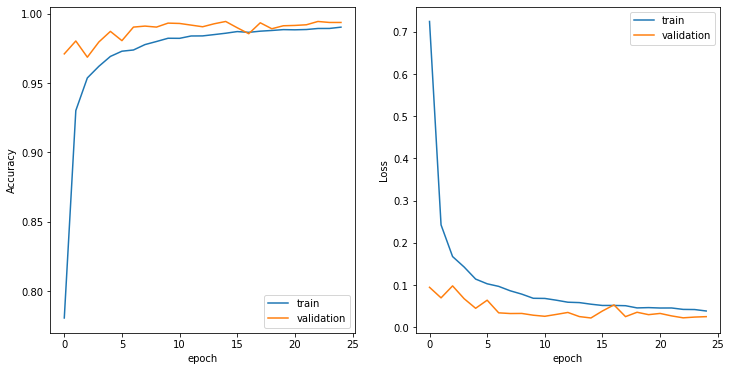

In [108]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_deep_normal.history['accuracy'])
plt.plot(history_deep_normal.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(history_deep_normal.history['loss'])
plt.plot(history_deep_normal.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

plt.show()

In [97]:
from sklearn.metrics import classification_report

preds = model_deep_normal.predict(X_valid / 255.)
preds = np.argmax(preds, axis=-1)
print(classification_report(y_valid, preds, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       395
           1     0.9979    0.9979    0.9979       485
           2     0.9976    0.9928    0.9952       417
           3     0.9977    0.9977    0.9977       443
           4     0.9832    0.9951    0.9891       411
           5     0.9975    0.9975    0.9975       395
           6     1.0000    0.9928    0.9964       414
           7     0.9951    0.9951    0.9951       412
           8     0.9906    0.9929    0.9917       423
           9     0.9926    0.9901    0.9913       405

    accuracy                         0.9952      4200
   macro avg     0.9952    0.9952    0.9952      4200
weighted avg     0.9953    0.9952    0.9952      4200



## Submission

In [60]:
res = np.argmax(model_deep_normal.predict(X_test), axis=-1)
print(res)

[2 0 9 ... 3 9 2]


In [62]:
submission = pd.DataFrame({
    'ImageId': range(1, len(res) + 1),
    'Label': res
})

In [64]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [65]:
submission.to_csv('digit_recognizer_submission.csv', index=False)